# Skeleton Notebook Deep Q-Learning Project (MHBF)

In [1]:
# Install required packages
#!pip install -q gym==0.15.4
#!pip install -q pycolab==1.2
#!pip install -q torch==1.2.0
#!pip install -q matplotlib==3.1.2
#!pip install -e .

In [40]:
!pip install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.6/259.6 MB 4.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 3.2 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 26.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 22.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 25.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 389.8/389.8 kB 8.7 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 23.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 21.4 MB/

In [112]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Import required packages
import gym
import gym_grid

import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim

import warnings
warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Part 1 - Environment Implementation

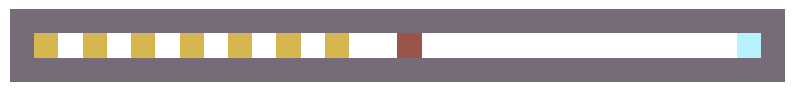

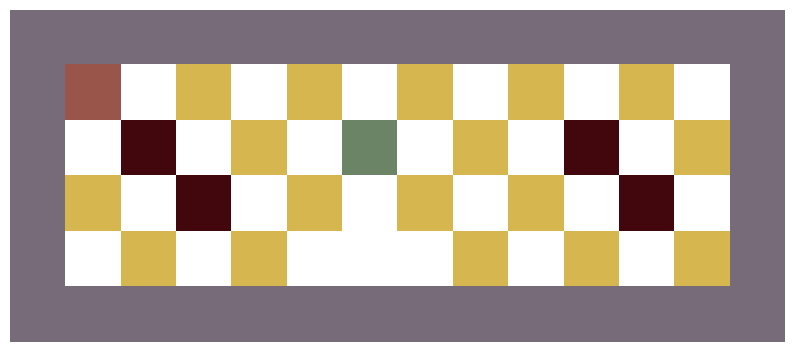

In [8]:
# Visualize the environment
plt.figure(figsize=(10, 10))

# T-Maze Environment
env_lin = gym.make("LinearTrack-v0")
_, obs_to_render = env_lin.reset_with_render()
env_lin.reset()
env_lin.render(obs_to_render)

plt.figure(figsize=(10, 10))
# Deadly Gridworld
env_grid = gym.make("DeadlyGrid-v0")
_, obs_to_render = env_grid.reset_with_render()
env_grid.reset()
env_grid.render(obs_to_render)

1300


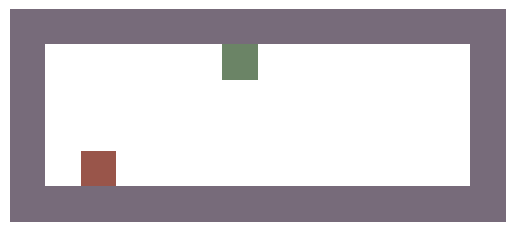

In [18]:
# Run random steps & Visualize the episode
from IPython import display

_, obs_to_render = env_grid.reset_with_render()
env_grid.render(obs_to_render)
rew_total = 0

i = 0
actions = [4] + [2 for i in range(11)]+[1]+[3 for i in range(11)]+[1]+[2 for i in range(11)]+[1]+[3 for i in range(11)]+[1]

while True:
    #action = env.action_space.sample()
    action = actions[i]
    i+=1
    _, rew , done, _, obs_to_render = env_grid.step_with_render(action)
    env_grid.render(obs_to_render)
    display.display(plt.gcf())
    display.clear_output(wait=True)
    rew_total += rew
    if done:
        break
print(rew_total)

# Part 2 - Deep Q-Learning Agents

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class DQN(nn.Module):
    def __init__(self, input_dim=384, output_dim=3):
        super(DQN, self).__init__()
        self.layer_in = nn.Linear(input_dim, 128)
        self.hidden_layer = nn.ReLU()
        self.layer_out = nn.Linear(128, output_dim)
    
    def forward(self, x):
        x = self.layer_in(x)
        x = self.hidden_layer(x)
        x = self.layer_out(x)
        return x

In [23]:
def epsilon_greedy_policy(state, epsilon, network):
    if np.random.rand() < epsilon:
        return np.random.randint(0, network.layer_out.out_features)
    else:
        with torch.no_grad():
            state = torch.FloatTensor(state).flatten().unsqueeze(0)
            q_values = q_network(state)
            return q_values.argmax().item()

In [118]:
def update_q_value(network, optimizer, loss_function, state, action, reward, 
                   next_state, gamma=0.99, eta=0.001):
    
    #Convert inputs to tensors
    state = torch.FloatTensor(state).flatten().unsqueeze(0)
    next_state = torch.FloatTensor(next_state).flatten().unsqueeze(0)

    # Forward pass to get Q-values
    q_values = network(state)

    # Get the Q-value for the chosen action
    q_value = q_values[0][action].squeeze(0)

    # Calculate the target Q-value
    with torch.no_grad():
        next_q_values = network(next_state)
        next_q_value = next_q_values.max(1)[0]
        target_q_value = q_value + eta*(reward + gamma * next_q_value - q_value)

    # Calculate loss
    loss = loss_function(q_value, target_q_value)

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(q_value, target_q_value)
    return target_q_value

In [120]:
# Const
epsilon = 1 #->0

# Init env and network
state = env_grid.reset()
q_network = DQN(6*14*5, 5)
optimizer = optim.Adam(q_network.parameters(), lr=0.001) 
loss_function = nn.MSELoss()

while True:
    
    action = epsilon_greedy_policy(state, epsilon, q_network)
    next_state, reward, done, info = env_grid.step(action)
    
    update_q_value(q_network, optimizer, loss_function, state, action, reward, 
                   next_state, gamma=0.99, eta=0.001)
    
    epsilon *= 0.8
    
    if done:
        break

tensor(-0.0266, grad_fn=<SqueezeBackward1>) tensor([-0.0265])
tensor(-0.0704, grad_fn=<SqueezeBackward1>) tensor([-0.0703])
tensor(0.0256, grad_fn=<SqueezeBackward1>) tensor([0.0257])
tensor(0.1334, grad_fn=<SqueezeBackward1>) tensor([0.2334])
tensor(0.2006, grad_fn=<SqueezeBackward1>) tensor([0.2005])
tensor(0.2576, grad_fn=<SqueezeBackward1>) tensor([0.2576])
tensor(0.3053, grad_fn=<SqueezeBackward1>) tensor([0.3052])
tensor(0.3463, grad_fn=<SqueezeBackward1>) tensor([0.3462])
tensor(0.3822, grad_fn=<SqueezeBackward1>) tensor([0.3821])
tensor(0.4142, grad_fn=<SqueezeBackward1>) tensor([0.4141])
tensor(0.4421, grad_fn=<SqueezeBackward1>) tensor([0.4420])
tensor(0.4671, grad_fn=<SqueezeBackward1>) tensor([0.4670])
tensor(0.4896, grad_fn=<SqueezeBackward1>) tensor([0.4894])
tensor(0.5090, grad_fn=<SqueezeBackward1>) tensor([0.5089])
tensor(0.5262, grad_fn=<SqueezeBackward1>) tensor([0.5260])
tensor(0.5416, grad_fn=<SqueezeBackward1>) tensor([0.5416])
tensor(0.5557, grad_fn=<SqueezeBackw